
## Principal Component Analysis and Data Classification for Subsurface Data Analytics

#### Qiwei Li
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering


### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)


### Executive Summary

* When we perform classification for the prediction, it is time consuming and difficult for high demensionality. 
* Therefore,it is important to ultilize PCA to reduce dimensionality and transverse the multivariance into less independent variables. 
* Also, choosing which classification model is a challenge to predict the data accurately. 
* We will compare the accuracy of seven classification model, such as Logistic Regression, K-Nearest Neighbors (KNN), and Support Vector Machine (SVM), to find the most accurate classification methodolody for the certain dataset.


## Data Preparation

### Import Packages

First of all, we need to import the package used in this workflow.

In [1]:
import os                                                 # Set current working directory
import pandas as pd                                       # DataFrames and plotting
import pandas.plotting as pd_plot                         # Matrix scatter plots
import numpy as np                                        # Arrays and matrix math
from sklearn.decomposition import PCA                     # PCA program from scikit learn (package for machine learning)
from sklearn.preprocessing import StandardScaler          # Standardize variables to mean of 0.0 and variance of 1.0
import matplotlib.pyplot as plt                           # Used in visualization
from matplotlib.colors import ListedColormap              # Color in the plot
from sklearn.model_selection import train_test_split      # Data split
from sklearn.preprocessing import StandardScaler          # For standardization
from sklearn.metrics import confusion_matrix              # Obtain confusion matrix of classification model
from sklearn.metrics import accuracy_score                # Obtain accuracy 
from sklearn.metrics import mean_squared_error            # SCORERSpecific measures to check our models

### Functions


* The plot_corr function is used for plotting the graphical correlation matrix.
* The classification_visualize is used for showing the results of classification

In [2]:
def plot_corr(dataframe,size=12):                         # Plot a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
# function from Professor Michael Pyrcz,https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb 
    
def classification_visualize(X_set_train, y_set_train, X_set_test, y_set_test, classifier, model = 'Logistic Regression'):
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    X1_train, X2_train = np.meshgrid(np.arange(start = X_set_train[:, 0].min() - 1, stop = X_set_train[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set_train[:, 1].min() - 1, stop = X_set_train[:, 1].max() + 1, step = 0.1))
    axs[0].contourf(X1_train, X2_train, classifier.predict(np.array([X1_train.ravel(), X2_train.ravel()]).T).reshape(X1_train.shape),
             alpha = 0.5, cmap = ListedColormap(('red', 'green', 'blue')))
    for i, j in enumerate(np.unique(y_set_train)):
        axs[0].scatter(X_set_train[y_set_train == j, 0], X_set_train[y_set_train == j, 1],marker='o',edgecolor='black',
                c = ListedColormap(('red', 'blue'))(i), label = j)   
    axs[0].set_ylim(X2_train.min(), X2_train.max())   
    axs[0].set_xlim(X1_train.min(), X1_train.max())
    axs[0].set_title(model+ '(Train set)')
    axs[0].set_xlabel('PC1')
    axs[0].set_ylabel('PC2')
    axs[0].legend()

    X1_test, X2_test = np.meshgrid(np.arange(start = X_set_test[:, 0].min() - 1, stop = X_set_test[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set_test[:, 1].min() - 1, stop = X_set_test[:, 1].max() + 1, step = 0.1))
    axs[1].contourf(X1_test, X2_test, classifier.predict(np.array([X1_test.ravel(), X2_test.ravel()]).T).reshape(X1_test.shape),
             alpha = 0.5, cmap = ListedColormap(('red', 'green', 'blue')))
    axs[1].set_xlim(X1_test.min(), X1_test.max())
    axs[1].set_ylim(X2_test.min(), X2_test.max())
    for i, j in enumerate(np.unique(y_set_test)):
        axs[1].scatter(X_set_test[y_set_test == j, 0], X_set_test[y_set_test== j, 1],marker='o',edgecolor='black',
                c = ListedColormap(('red', 'blue'))(i), label = j)
    axs[1].set_title(model+ ' (Test set)')
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC2')
    axs[1].legend()
    plt.show()

### Load Data


#### Set the working directory¶

In [3]:
os.chdir(r"C:\Users\12818\Desktop\Graduate\PGE 383 MACHINE LEARNING\Code")  

#### Read the data table

In [4]:
df = pd.read_csv("unconv_MV.csv")     # Read the data table
num = df._get_numeric_data()                  # Get the values of data       
num[num < 0] = 0                              # Truncate negative values to zeros 
df.describe().transpose()             # Describe the data

,count,mean,std,min,25%,50%,75%,max
WellIndex,1000.0,500.500000,288.819436,1.000000,250.75000,500.50000,750.250000,1000.00000
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


We choose porosity, permeability, AI, brittle, TOC and VR as predictor feactures in the dataset. And the response is production. To classification, we would like to assign hign produtcion as 1 and low production as 0.

#### Production classification

In [5]:
df['cProd'] = np.where(df['Production']>=4000, 1, 0)    # Assigne high producition as 1 and low production as 0

#### Dataframe preparation

In [6]:
df = df.iloc[:,[1,2,3,4,5,6,8]]          # Use columns 1-6 and 8 
df.describe().transpose()                # Describe the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.95046,3.029634,5.40,12.8575,14.985,17.0800,24.65
LogPerm,1000.0,1.39888,0.405966,0.12,1.1300,1.390,1.6800,2.58
AI,1000.0,2.98261,0.577629,0.96,2.5775,3.010,3.3600,4.70
Brittle,1000.0,49.73148,15.033593,0.00,39.7225,49.680,59.1700,93.47
TOC,1000.0,1.00617,0.499838,0.00,0.6400,0.995,1.3600,2.71
VR,1000.0,1.99117,0.308194,0.90,1.8100,2.000,2.1725,2.90
cProd,1000.0,0.11600,0.320385,0.00,0.0000,0.000,0.0000,1.00


### Basic Data  Visualization

#### Show the histogram of original features

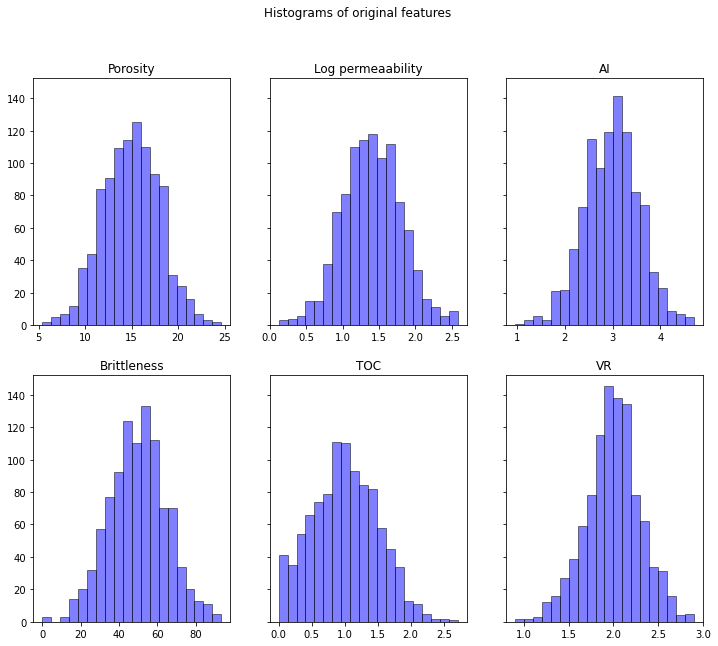

In [7]:
X = df.iloc[:, :-1].values              # Obtain X values 
y = df.iloc[:, -1].values               # Obtain y values
f, axs = plt.subplots(2, 3, sharey=True, figsize=(12,10))
axs[0,0].hist(X[:,0], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[0,0].set_title('Porosity'); 
axs[0,1].hist(X[:,1], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[0,1].set_title('Log permeaability'); 
axs[0,2].hist(X[:,2], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[0,2].set_title('AI'); 
axs[1,0].hist(X[:,3], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[1,0].set_title('Brittleness');
axs[1,1].hist(X[:,4], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[1,1].set_title('TOC'); 
axs[1,2].hist(X[:,5], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[1,2].set_title('VR');
f.suptitle('Histograms of original features') 
plt.show()

#### Correlation matrix 

In [8]:
corr_matrix = np.corrcoef(df, rowvar = False)             # Obtain the correlation matrix
print(np.around(corr_matrix,3))                           # print the correlation matrix 

[[ 1.     0.808 -0.506 -0.253  0.712  0.085  0.499]
 [ 0.808  1.    -0.325 -0.15   0.507  0.046  0.419]
 [-0.506 -0.325  1.     0.168 -0.547  0.487 -0.243]
 [-0.253 -0.15   0.168  1.    -0.244  0.296 -0.008]
 [ 0.712  0.507 -0.547 -0.244  1.     0.307  0.373]
 [ 0.085  0.046  0.487  0.296  0.307  1.     0.131]
 [ 0.499  0.419 -0.243 -0.008  0.373  0.131  1.   ]]


#### Visualize the correlation matrix.

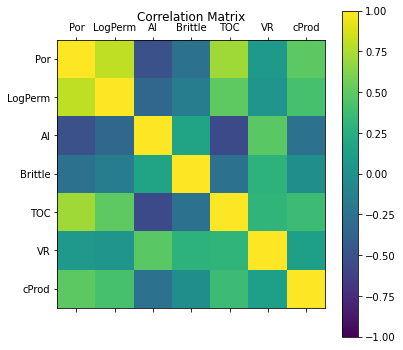

In [9]:
plot_corr(df,6)                                      # Plot the correlation matrix
plt.show()

#### Matrix scatter

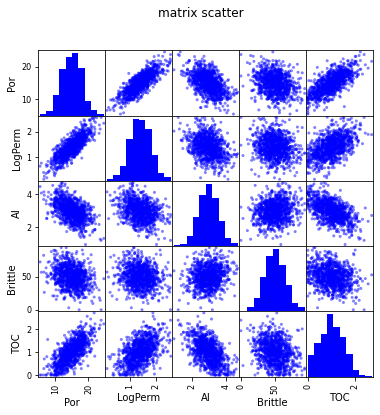

In [10]:
pd_plot.scatter_matrix(df.iloc[:,0:5],alpha = 0.5,figsize=(6, 6),color = 'blue', hist_kwds={'color':['blue']}) # pandas matrix scatter plot
plt.suptitle('matrix scatter')
plt.show()

## Dimensionality Reduction 

### Feature Scaling

In [11]:
sc = StandardScaler()                     #standardize the features
X_sc = sc.fit_transform(X)

### Visualize the standardized features

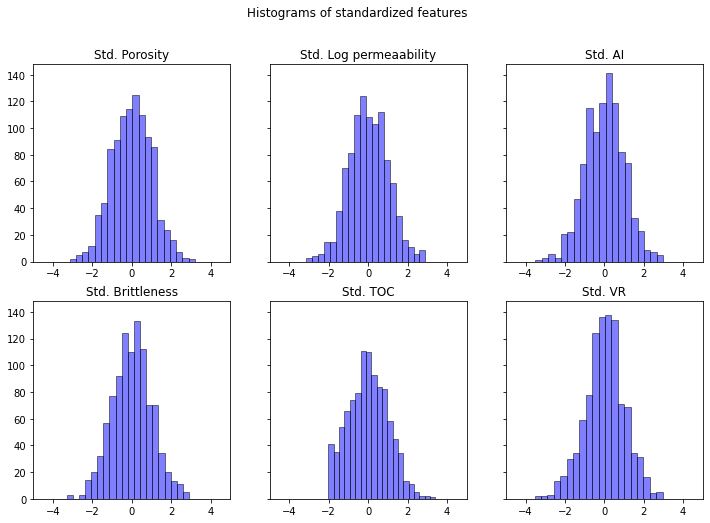

In [12]:
f, axs = plt.subplots(2, 3, sharey=True, figsize=(12,8))
f.suptitle('Histograms of standardized features') 
axs[0,0].hist(X_sc[:,0], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[0,0].set_title('Std. Porosity'); axs[0,0].set_xlim(-5,5)
axs[0,1].hist(X_sc[:,1], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[0,1].set_title('Std. Log permeaability'); axs[0,1].set_xlim(-5,5)
axs[0,2].hist(X_sc[:,2], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[0,2].set_title('Std. AI'); axs[0,2].set_xlim(-5,5)
axs[1,0].hist(X_sc[:,3], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[1,0].set_title('Std. Brittleness');axs[1,0].set_xlim(-5,5)
axs[1,1].hist(X_sc[:,4], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[1,1].set_title('Std. TOC');axs[1,1].set_xlim(-5,5) 
axs[1,2].hist(X_sc[:,5], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[1,2].set_title('Std. VR'); axs[1,2].set_xlim(-5,5)
plt.show()

### Demostration of Dimensional Reduction

In [13]:
pca = PCA(n_components = 2)                   #Reduce dimensional to 2
X_PCA = pca.fit_transform(X_sc)
print(X_PCA)

[[ 1.33524501  0.86287154]
 [ 1.28689517  0.92293084]
 [ 2.14687881 -2.66667027]
 ...
 [ 1.31119848 -1.25160481]
 [ 2.35963301 -1.62997914]
 [ 0.35735905 -0.43535134]]


It is clearly show that the predictor feactures have reduced to two.

### Visualize the PCA result

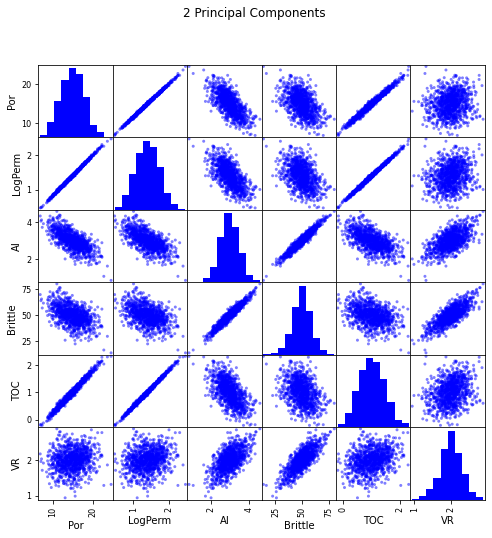

In [14]:
features = ['Por','LogPerm','AI','Brittle','TOC','VR']
mu = np.mean(X, axis=0)
sd = np.std(X, axis=0)
xhat = np.dot(pca.transform(X_sc)[:,:2], pca.components_[:2,:])
xhat = sd*xhat + mu
df_2d = pd.DataFrame(data=xhat,columns=features)                     
#Above calculation is from rofessor Michael Pyrcz,https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb 
pd_plot.scatter_matrix(df_2d,alpha = 0.5,figsize=(8, 8),color = 'blue', hist_kwds={'color':['blue']})
plt.suptitle('2 Principal Components')
plt.show()

### Visualize the 2 principle components.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


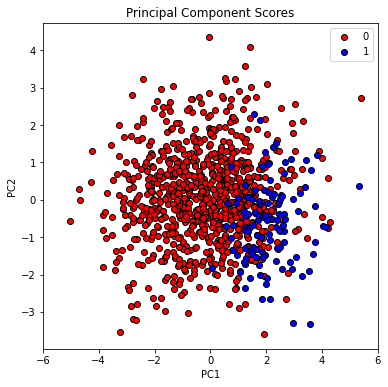

In [15]:
plt.subplots(1, 1,  figsize=(6,6))
for i, j in enumerate(np.unique(y)):
    plt.scatter(X_PCA[y == j, 0], X_PCA[y == j, 1],marker='o',edgecolor='black',
                c = ListedColormap(('red', 'blue'))(i), label = j)
plt.legend()
plt.xlabel('PC1')
plt.xlim([-6,6])
plt.ylabel('PC2')
plt.title('Principal Component Scores')
plt.show()

The distribution of 2 principal components in high production (1) and low production (0) is shown. The classification is chaos and not a obvious line. Then we can perform the classification model to predict.

## Classification 

### Split data 


#### Spiltting the dataset into the Training set and Test set

In [16]:
 X_train, X_test, y_train, y_test = train_test_split(X_PCA,y,test_size = 0.2, random_state = 0) #Data split

#### Visuslize the distribution of traning and testing data

(-5.0, 5.0)

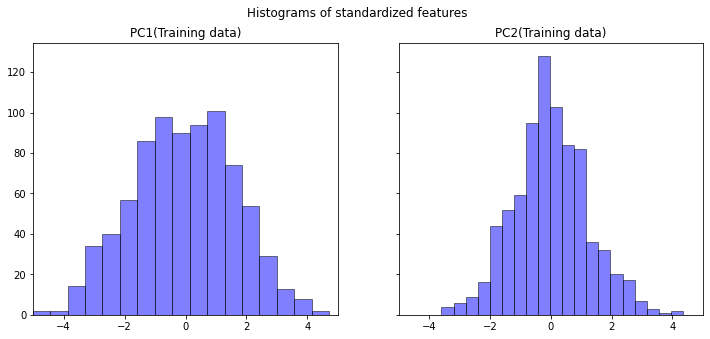

In [17]:
f, axs = plt.subplots(1, 2, sharey=True, figsize=(12,5))
f.suptitle('Histograms of standardized features') 
axs[0].hist(X_train[:,0], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[0].set_title('PC1(Training data)'); axs[0].set_xlim(-5,5)
axs[1].hist(X_train[:,1], alpha = 0.5, color = 'blue', edgecolor = 'black', bins=20); axs[1].set_title('PC2(Training data)'); axs[1].set_xlim(-5,5)

#### Generate accuracy score array

In [18]:
accuracy_score_all= np.zeros(8)              #generate an array for colleting the accurace score of all models to check the goodness of the model

### Logistic Regression

#### Train the model

In [19]:
from sklearn.linear_model import LogisticRegression           # For logistic regression
classifier_lin = LogisticRegression(random_state = 0)
classifier_lin.fit(X_train, y_train)                           #Train the model from training data

LogisticRegression(random_state=0)

#### Predict the test data

In [20]:
y_pred_lin = classifier_lin.predict(X_test)                      # Predict the testing data

#### Model Checking

Check the model and summary metrics for model performance.

In [21]:
cm = confusion_matrix(y_test, y_pred_lin)                        # Obtain the confusion matrix
print(cm)                                                        # Print the confusion matrix
accuracy_score_logistic = accuracy_score(y_test, y_pred_lin)     # Obtain the accurate score of the model
print('The accuracy score is:' + str(accuracy_score_logistic))                                   # Print the accurate score
accuracy_score_all[0] =(accuracy_score_logistic)               # Add the accurate score into the collection array
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lin, labels=[0,1]))   #Obtain the table of model performance summary

[[170   8]
 [ 15   7]]
The accuracy score is:0.885
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       178
           1       0.47      0.32      0.38        22

    accuracy                           0.89       200
   macro avg       0.69      0.64      0.66       200
weighted avg       0.87      0.89      0.88       200



#### Visualize the result

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

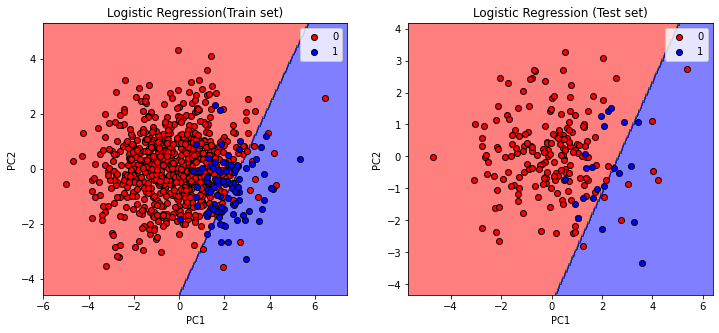

In [22]:
classification_visualize(X_train, y_train, X_test, y_test, classifier_lin, model = 'Logistic Regression') #using classification_visualize function 

##### The accuracy of the model is 0.885.The logistic regression is suitable for linear classification.

### K-Nearest Neighbors (KNN)


#### Tune the hyperparameter

* Find the neighbors that can minimize the squared error for testing data

In [23]:
from sklearn.neighbors import KNeighborsClassifier                  # For KNN
mse_test = np.zeros(10)                                             # To collect MSE
for i in range (1,11):                                              #Tune the hyperparameter
    classifier_knn = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2)
    classifier_knn.fit(X_train, y_train)                            # Train the model from training data
    mse_test[i-1] = mean_squared_error(y_test, classifier_knn.predict(X_test))  #Collect MSE
(min_mse,n_nei) = min((v,i) for i,v in enumerate(mse_test))
print (min_mse,n_nei)
n_neighbors = n_nei + 1                                             # Obtain the number of neighbors to minimize the MSE
print('Number of neighbors is:' + str(n_neighbors))

0.11 9
Number of neighbors is:10


#### Train the data using the tuned hyperparameter

In [24]:
classifier_knn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = 'minkowski', p = 2)
classifier_knn.fit(X_train, y_train)                             # Train the model from training data

KNeighborsClassifier(n_neighbors=10)

#### Predict the test data

In [25]:
y_pred_knn = classifier_knn.predict(X_test)                      # Predict the testing data

#### Model Checking

Check the model and summary metrics for model performance.

In [26]:
cm = confusion_matrix(y_test, y_pred_knn)                        # Obtain the confusion matrix
print(cm)                                                        # Print the confusion matrix
accuracy_score_knn = accuracy_score(y_test, y_pred_knn)          # Obtain the accurate score of the model
print(accuracy_score_knn)                                        # Print the accurate score
accuracy_score_all[1] =(accuracy_score_knn)                      # Add the accurate score into the collection array
print(classification_report(y_test, y_pred_knn, labels=[0,1]))   #Obtain the table of model performance summary

[[172   6]
 [ 16   6]]
0.89
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       178
           1       0.50      0.27      0.35        22

    accuracy                           0.89       200
   macro avg       0.71      0.62      0.65       200
weighted avg       0.87      0.89      0.88       200



#### Visualize the result

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

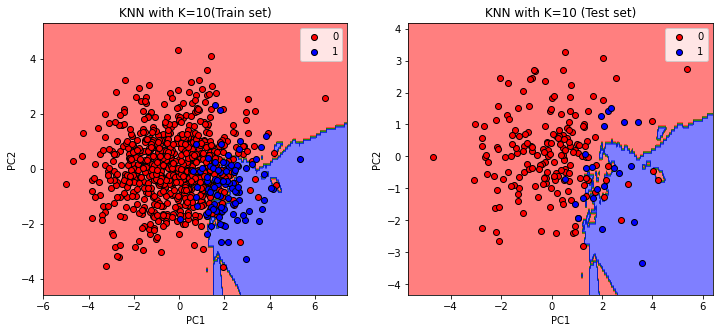

In [27]:
classification_visualize(X_train, y_train, X_test, y_test, classifier_knn, model = 'KNN with K='+str(n_neighbors))  #using classification_visualize function 

##### The accuracy of this KNN model is 0.89 for 10 neighbors. Better than logistic model.

### Support Vector Machine (SVM) -- linear


#### Tune the hyperpapameter

*  Find the optimum penalty to balance the bias and variance. 

In [28]:
from sklearn.svm import SVC                                           # For SVM
c= [0.1,1,10]                                                         # Testing C from 0.1, 1, and 10
mse_test = np.zeros(3)
for i in range (0,3):                                                 #Tune the hyperparameter
    classifier_svm = SVC(kernel = 'linear', random_state = 0, C=c[i])
    classifier_svm.fit(X_train, y_train)                              # Train the model from training data
    mse_test[i] = mean_squared_error(y_test, classifier_svm.predict(X_test)) #Collect the MSE
(min_mse,i) = min((v,i) for i,v in enumerate(mse_test))
print (min_mse,i)
C= c[i]                                                              # Obtain the optimum C
print('C='+str(C))

0.12 0
C=0.1


Smaller C, higer bias, lower variance.The classifier is more tolerant with misclassified data points.   

#### Train the model using the tuned hyperparameter

In [29]:
classifier_svm = SVC(kernel = 'linear', random_state = 0,C=C)
classifier_svm.fit(X_train, y_train)                             #Train the model from training data

SVC(C=0.1, kernel='linear', random_state=0)

#### Predict the test data

In [30]:
y_pred_svm = classifier_svm.predict(X_test)                      # Predict the testing data

#### Model Checking

Check the model and summary metrics for model performance.

In [31]:
cm = confusion_matrix(y_test, y_pred_svm)                        # Obtain the confusion matrix
print(cm)                                                        # Print the confusion matrix
accuracy_score_svm = accuracy_score(y_test, y_pred_svm)          # Obtain the accurate score of the model
print(accuracy_score_svm)                                        # Print the accurate score
accuracy_score_all[2]=(accuracy_score_svm)                       # Add the accurate score into the collection array
print(classification_report(y_test, y_pred_svm, labels=[0,1]))   #Obtain the table of model performance summary

[[172   6]
 [ 18   4]]
0.88
              precision    recall  f1-score   support

           0       0.91      0.97      0.93       178
           1       0.40      0.18      0.25        22

    accuracy                           0.88       200
   macro avg       0.65      0.57      0.59       200
weighted avg       0.85      0.88      0.86       200



#### Visualize the result

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

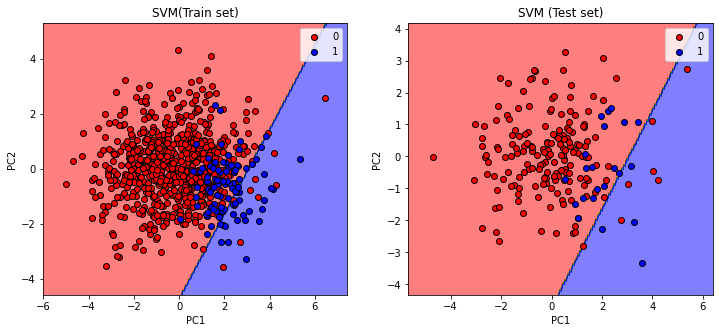

In [32]:
classification_visualize(X_train, y_train, X_test, y_test, classifier_svm, model = 'SVM')  #using classification_visualize function 

##### The accuracy of this Linear SVM model is 0.88 for C= 0.1. For this dataset, it is not suitable for linear model.

### Kernel SVM -- ploy


#### Tune the hyperparameter

* Find the optimum C and degree to minimize MSE.

In [33]:
C_range= [0.1,1,10,100]                            # Test C from 0.1, 1, 10 and 100
degree_range = [2,3,4,5]                           # Test degree from 2, 3, 4 and 5
mse_test = np.zeros(16)
i = 0                                              # Tune the hyperparameter
for C in C_range:
    for degree in degree_range:
        classifier_svm_poly = SVC(kernel = 'poly',C=C, degree=degree)
        classifier_svm_poly.fit(X_train,y_train)
        mse_test[i] = mean_squared_error(y_test, classifier_svm_poly.predict(X_test))
        i = i+1

(min_mse,i) = min((v,i) for i,v in enumerate(mse_test))
print (min_mse,i)                          # Obtain the minimum MSE
C= C_range[i//4]                           # Obtain the corresponding C
degree= degree_range[i%4]                  # Obtian the corresponding degress
print ('c=' +str(C))
print ('degree = '+str(degree))

0.11 0
c=0.1
degree = 2


#### Train the model using the tuned hyperparameter

In [34]:
classifier_svm_poly = SVC(kernel = 'poly',C=C, degree=degree)
classifier_svm_poly.fit(X_train,y_train)                             #Train the model from training data

SVC(C=0.1, degree=2, kernel='poly')

#### Predict the test data

In [35]:
y_pred_svm_poly = classifier_svm_poly.predict(X_test)                      # Predict the testing data

#### Model Checking

Check the model and summary metrics for model performance.

In [36]:
cm_ksvm = confusion_matrix(y_test, y_pred_svm_poly)                    # Obtain the confusion matrix
print(cm)                                                              # Print the confusion matrix
accuracy_score_svm_poly = accuracy_score(y_test, y_pred_svm_poly)      # Obtain the accurate score of the model
print(accuracy_score_svm_poly)                                         # Print the accurate score
accuracy_score_all[3]=(accuracy_score_svm_poly)                        # Add the accurate score into the collection array
print(classification_report(y_test, y_pred_svm_poly, labels=[0,1]))    #Obtain the table of model performance summary

[[172   6]
 [ 18   4]]
0.89
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       178
           1       0.00      0.00      0.00        22

    accuracy                           0.89       200
   macro avg       0.45      0.50      0.47       200
weighted avg       0.79      0.89      0.84       200



C:\Users\12818\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Visualize the result

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

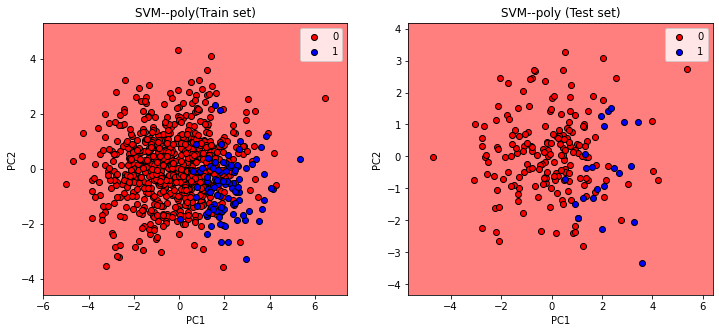

In [37]:
classification_visualize(X_train, y_train, X_test, y_test, classifier_svm_poly, model = 'SVM--poly')  #using classification_visualize function 

##### The accuracy of this Poly SVM model is 0.89 for C= 0.1 and degree of 2. It is better than using linear kernel. However, the computational time is longer than other models.

### Kernel SVM --rbf


#### Tune the hyperparameter

* Change the value of $\gamma$ and C.

In [38]:
C_range = [0.1,1,10,100]                           # Test C from 0.1, 1, 10 and 100
gamma_range = [0.01,1,10,100]                      # Test gamma from 0.1 1, 10 and 100
mse_test = np.zeros(16)
i = 0
for C in C_range:                                  # Tune the hyperparameter
    for gamma in gamma_range:   
        classifier_svm_rbf = SVC(kernel = 'rbf',C=C, gamma=gamma)
        classifier_svm_rbf.fit(X_train,y_train)
        mse_test[i] = mean_squared_error(y_test, classifier_svm_rbf.predict(X_test))
        i = i+1

(min_mse,i) = min((v,i) for i,v in enumerate(mse_test))
print (min_mse,i)                         # Obtian the min MSE
C= C_range[i//4]                          # Obtain the corresponding C
gamma= gamma_range[i%4]                   # Obtian the corresponding degress
print ('c=' +str(C))
print ('gamma = '+str(gamma))

0.1 12
c=100
gamma = 0.01


* Low $\gamma$ and high C will lead to low variance, high bias.

#### Train the model using the tuned hyperparameter

In [39]:
classifier_svm_rbf = SVC(kernel = 'rbf', random_state = 0,C=C,gamma =gamma)
classifier_svm_rbf.fit(X_train, y_train)                              #Train the model from training data

SVC(C=100, gamma=0.01, random_state=0)

#### Predict the test data

In [40]:
y_pred_svm_rbf = classifier_svm_rbf.predict(X_test)                      # Predict the testing data

#### Model Checking

Check the model and summary metrics for model performance.

In [41]:
cm_ksvm = confusion_matrix(y_test, y_pred_svm_rbf)                    # Obtain the confusion matrix
print(cm)                                                             # Print the confusion matrix
accuracy_score_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)       # Obtain the accurate score of the model
print(accuracy_score_svm_rbf)                                         # Print the accurate score
accuracy_score_all[4]=(accuracy_score_svm_rbf)                        # Add the accurate score into the collection array
print(classification_report(y_test, y_pred_svm_rbf, labels=[0,1]))    # Obtain the table of model performance summary

[[172   6]
 [ 18   4]]
0.9
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       178
           1       0.58      0.32      0.41        22

    accuracy                           0.90       200
   macro avg       0.75      0.65      0.68       200
weighted avg       0.88      0.90      0.89       200



#### Visualize the result

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

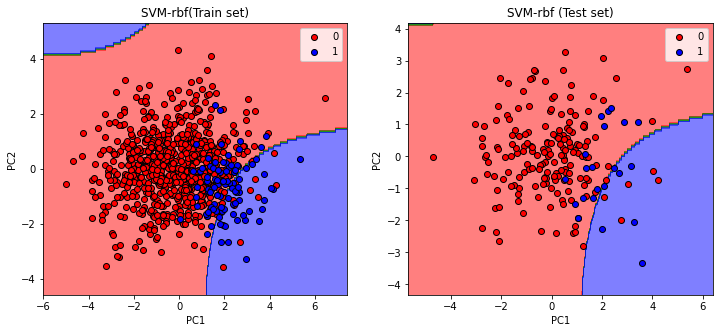

In [42]:
classification_visualize(X_train, y_train, X_test, y_test, classifier_svm_rbf, model = 'SVM-rbf')  #using classification_visualize function

##### The accuracy of this RBF SVM model is 0.90 for C= 100 and gamma of 0.01. It is better.

### Decision Tree Classification


#### Tune the hyperparameter

* Choose from gini and entropy

In [43]:
from sklearn.tree import DecisionTreeClassifier                    # For Decision tree 
cretia = ['gini', 'entropy']                                       # Choose from gini and entropy
mse_test = np.zeros(2)
for i in range (0,2):                                              # Tune the hyperparameter
    classifier_dec = DecisionTreeClassifier(criterion = cretia[i], random_state = 0)
    classifier_dec.fit(X_train, y_train)                            # Train the model from training data
    mse_test[i] = mean_squared_error(y_test, classifier_dec.predict(X_test))
(min_mse,i) = min((v,i) for i,v in enumerate(mse_test))
print (min_mse,i)                                                   # Obtain the min MSE
criterion = cretia[i]                                               # Obtain the corresponding cretia 
print('Criterion is: '+ criterion)

0.125 1
Criterion is: entropy


#### Train the model using the tuned hyperparameter

In [44]:
classifier_dec = DecisionTreeClassifier(criterion = cretia[i], random_state = 0)
classifier_dec.fit(X_train, y_train)                              #Train the model from training data

DecisionTreeClassifier(criterion='entropy', random_state=0)

#### Predict the test data

In [45]:
y_pred_dec = classifier_dec.predict(X_test)                      # Predict the testing data

#### Model Checking

Check the model and summary metrics for model performance.

In [46]:
cm = confusion_matrix(y_test, y_pred_dec)                        # Obtain the confusion matrix
print(cm)                                                        # Print the confusion matrix
accuracy_score_dec = accuracy_score(y_test, y_pred_dec)          # Obtain the accurate score of the model
print(accuracy_score_dec)                                        # Print the accurate score
accuracy_score_all[5]=(accuracy_score_dec)                    # Add the accurate score into the collection array
print(classification_report(y_test, y_pred_dec, labels=[0,1]))   #Obtain the table of model performance summary

[[166  12]
 [ 13   9]]
0.875
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       178
           1       0.43      0.41      0.42        22

    accuracy                           0.88       200
   macro avg       0.68      0.67      0.67       200
weighted avg       0.87      0.88      0.87       200



###### Visualize the result

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

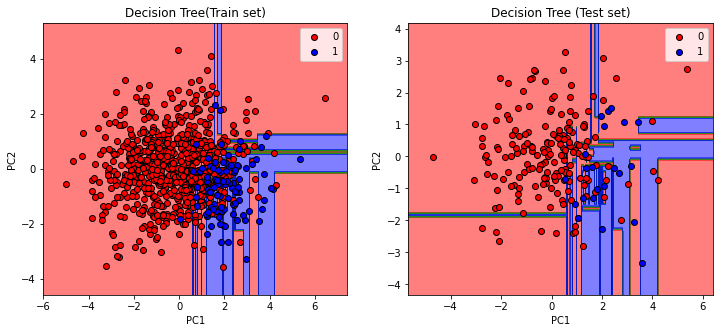

In [47]:
classification_visualize(X_train, y_train, X_test, y_test, classifier_dec, model = 'Decision Tree')   #using classification_visualize function 

##### The accuracy of Desicion Tree model is 0.875 with entropy. It is not so accurate.

### Naive Bayes Classification


#### Train the model

In [48]:
from sklearn.naive_bayes import GaussianNB
classifier_NB = GaussianNB()
classifier_NB.fit(X_train, y_train)                              #Train the model from training data

GaussianNB()

#### Predict the test data

In [49]:
y_pred_NB = classifier_NB.predict(X_test)                        # Predict the testing data

#### Model Checking

Check the model and summary metrics for model performance.

In [50]:
cm = confusion_matrix(y_test, y_pred_dec)                        # Obtain the confusion matrix
print(cm)                                                        # Print the confusion matrix
accuracy_score_NB = accuracy_score(y_test, y_pred_NB)            # Obtain the accurate score of the model
print(accuracy_score_NB)                                         # Print the accurate score
accuracy_score_all[6]=(accuracy_score_NB)                     # Add the accurate score into the collection array
print(classification_report(y_test, y_pred_NB, labels=[0,1]))   #Obtain the table of model performance summary

[[166  12]
 [ 13   9]]
0.89
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       178
           1       0.50      0.32      0.39        22

    accuracy                           0.89       200
   macro avg       0.71      0.64      0.66       200
weighted avg       0.87      0.89      0.88       200



###### Visualize the result

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

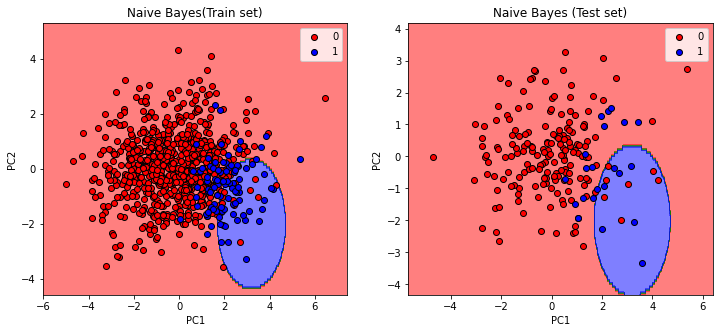

In [51]:
classification_visualize(X_train, y_train, X_test, y_test, classifier_NB, model = 'Naive Bayes')  #using classification_visualize function 

##### The accuracy of Naive Bayes model is 0.89. This accuracy is not bad.

### Radom Forest Classification


#### Tune the hyperparameter

* Change the value of estimators.

In [52]:
from sklearn.ensemble import RandomForestClassifier
mse_test = np.zeros(10)
for i in range (1,11):                                             #Tune the hyperparameter
    classifier_RF = RandomForestClassifier(n_estimators = i, criterion = 'gini', random_state = 0)
    classifier_RF.fit(X_train, y_train)                            # Train the model from training data
    mse_test[i-1] = mean_squared_error(y_test, classifier_RF.predict(X_test))
(min_mse,n) = min((v,i) for i,v in enumerate(mse_test))
print (min_mse,n)                                                   # Obtain the min MSE
n_estimators = n + 1
print('Number of estimators is:'+str(n_estimators))                 # Obtain the corresponding number of estimators

0.105 1
Number of estimators is:2


#### Train the model using the tuned hyperparameter

In [53]:
classifier_RF = RandomForestClassifier(n_estimators = n_estimators, criterion = 'gini', random_state = 0)
classifier_RF.fit(X_train, y_train)                              #Train the model from training data 

RandomForestClassifier(n_estimators=2, random_state=0)

#### Predict the test data

In [54]:
y_pred_RF = classifier_RF.predict(X_test)                        # Predict the testing data

#### Model Checking

Check the model and summary metrics for model performance.

In [55]:
cm = confusion_matrix(y_test, y_pred_dec)                        # Obtain the confusion matrix
print(cm)                                                        # Print the confusion matrix
accuracy_score_RF = accuracy_score(y_test, y_pred_RF)            # Obtain the accurate score of the model
print(accuracy_score_RF)                                         # Print the accurate score
accuracy_score_all[7]=(accuracy_score_RF)                     # Add the accurate score into the collection array
print(classification_report(y_test, y_pred_RF, labels=[0,1]))   #Obtain the table of model performance summary

[[166  12]
 [ 13   9]]
0.895
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       178
           1       0.56      0.23      0.32        22

    accuracy                           0.90       200
   macro avg       0.73      0.60      0.63       200
weighted avg       0.87      0.90      0.87       200



#### Visualize the result

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

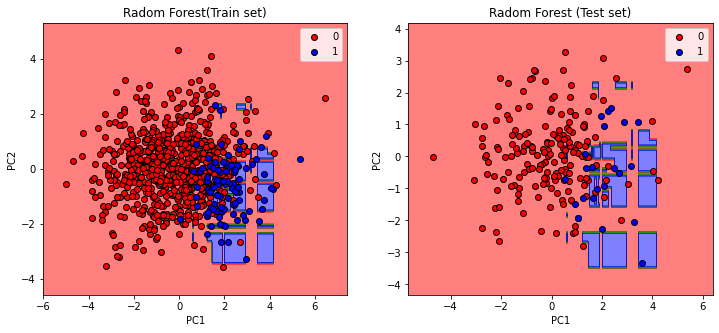

In [56]:
classification_visualize(X_train, y_train, X_test, y_test, classifier_RF, model = 'Radom Forest')   #using classification_visualize function 

##### The accuracy of Random Forest  model is 0.895 with 2 estimators. 

## Results

### Compare accuracy of each classification model


In [57]:
model_list = ["Logistic Regression",'KNN',"SVM-linear","SVM-poly","SVM-rbf", "Naive Bayes", " Decision Tree", "Random Forest"] # Generate the model list
classifier_all = [classifier_lin,classifier_knn,classifier_svm,classifier_svm_poly,classifier_svm_rbf,classifier_NB,classifier_dec,classifier_RF ] # Generate classifier list 
from tabulate import tabulate   #show in table
print(tabulate([accuracy_score_all], headers=model_list))   # Generate a table to list the model and its accuracy score 


  Logistic Regression    KNN    SVM-linear    SVM-poly    SVM-rbf    Naive Bayes     Decision Tree    Random Forest
---------------------  -----  ------------  ----------  ---------  -------------  ----------------  ---------------
                0.885   0.89          0.88        0.89        0.9          0.875              0.89            0.895


#### Visualize the result of each model

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

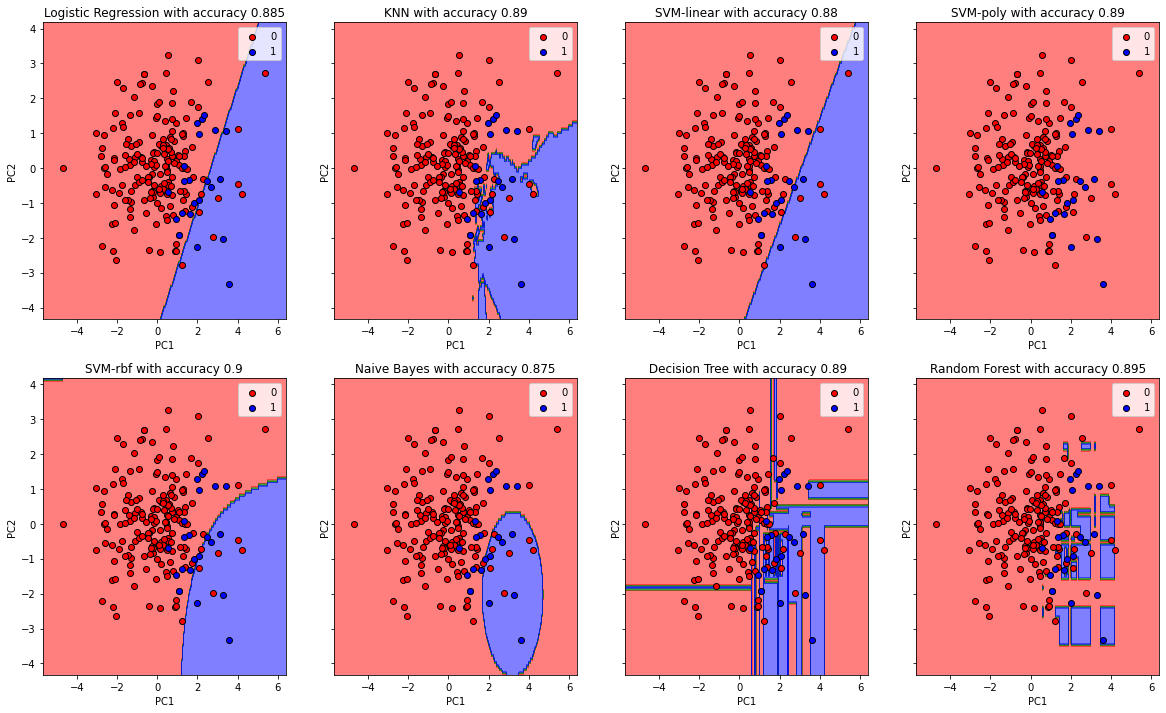

In [58]:
fig, axs = plt.subplots(2,4,figsize=(20,12), sharey=True)
X1_test, X2_test = np.meshgrid(np.arange(start = X_test[:, 0].min() - 1, stop = X_test[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_test[:, 1].min() - 1, stop = X_test[:, 1].max() + 1, step = 0.1))
for ind in range (0,2):
    for jnd in range (0,4):
        axs[ind,jnd].contourf(X1_test, X2_test, classifier_all[ind*4+jnd].predict(np.array([X1_test.ravel(), X2_test.ravel()]).T).reshape(X1_test.shape),
                 alpha = 0.5, cmap = ListedColormap(('red', 'green', 'blue')))
        axs[ind,jnd].set_xlim(X1_test.min(), X1_test.max())
        axs[ind,jnd].set_ylim(X2_test.min(), X2_test.max())
        for i, j in enumerate(np.unique(y_test)):
            axs[ind,jnd].scatter(X_test[y_test == j, 0], X_test[y_test== j, 1],marker='o',edgecolor='black',
                c = ListedColormap(('red', 'blue'))(i), label = j)
        axs[ind,jnd].set_title(model_list[ind*4+jnd]+' with accuracy '+str(accuracy_score_all[ind*4+jnd]))
        axs[ind,jnd].set_xlabel('PC1')
        axs[ind,jnd].set_ylabel('PC2')
        axs[ind,jnd].legend()
plt.show()


* We compared the accuracy of each  bias-variance trade-off model. The best classification model is RBF kernel SVM with  the highest accuracy. The second best model is Random Forest with accuracy of 0.895.

#### Best classification model


In [59]:
(max_accuracy,index) = max((v,i) for i,v in enumerate(accuracy_score_all))  # Find the maxmimum accurate score and the correponding model
print (max_accuracy,index)
classifier = classifier_all[index]            # Choose the best model
print("The best classification model is:" + model_list[index])  # Print the best model
print("The accuracte score is:" + str(max_accuracy))                   # Print the maximum accurate socre

0.9 4
The best classification model is:SVM-rbf
The accuracte score is:0.9


#### Vsualize the result

The prediction result is shown:


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

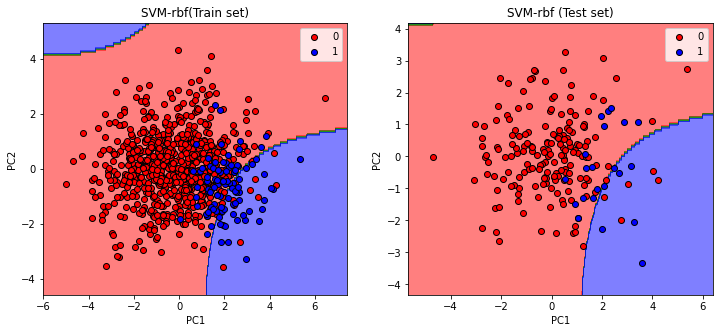

In [60]:
print('The prediction result is shown:')
classification_visualize(X_train, y_train, X_test, y_test, classifier, model = model_list[index])   #visualize the prediction result with the best model

 ##### Use RBF model to segment facies with a good bias-variance trade-off. 

### Prediction for other specific features

Then we can apply the trained model to predict the production classisfication for some specific 
features. Here we choose an random combination of 6 features.

In [61]:
predict_feature = [15.0, 1.4, 3.0, 49.7, 1.0, 2.0]
print("porosity is :" + str(predict_feature[0]) + "\n" + "log permeability is:" + str(predict_feature[1]) + "\n"
      "AI is:" + str(predict_feature[2]) + "\n"+ "Brittle is:" + str(predict_feature[3]) + "\n"+
      "TOC is:" + str(predict_feature[4]) + "\n"+ "VR is:" + str(predict_feature[5]))

porosity is :15.0
log permeability is:1.4
AI is:3.0
Brittle is:49.7
TOC is:1.0
VR is:2.0


In [62]:
from tabulate import tabulate   #show in table
print(tabulate([["15.0", "1.4", "3.0", "49.7", "1.0", "2.0"]], headers=["Por", "Log Perm", "AI", "Brittle","TOC","VR"]))

  Por    Log Perm    AI    Brittle    TOC    VR
-----  ----------  ----  ---------  -----  ----
   15         1.4     3       49.7      1     2


Reduce the dimension to 2. 

In [63]:
X_feature = sc.transform ([predict_feature])  # Standardize the features
X_feature = pca. transform (X_feature)        # Reduce dimension

Predict the features

In [64]:
y_feature = classifier.predict(X_feature)
if y_feature == 0:
    print('The corresponding production is belong to low production(0).' )
elif y_feature == 1:
    print('The corresponding production is belong to high production(1).' )

The corresponding production is belong to low production(0).


## Conclusions:
* First we used PCA to reduce the demensions to 2.
* Then we tuned hypermeters for each model seperately to obtain the good bias-variance trade-off (minimum MSE) model.
* RBF model with C = 100 and $\gamma$ = 0.01 can have a good bias-variance trade-off to classify the production with the highest accuacy. 
* It combines the accuracy (0.9) and efficiency.
* The second good model is random forest. 


I hope this was helpful,

*Qiwei Li*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
